In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def diag(ax):
    return ax.plot([0, 1], [0, 1], color="grey", linestyle="--", transform=ax.transAxes)

In [2]:
from event2vec_modified.datasets import DY1JDataset

data = DY1JDataset.from_lhe("data/dy1j.lhe.gz")
data

DY1JDataset(
  observables=f32[10000,12],
  gen_parameters=f32[10000,2],
  latent_data=f32[10000,2]
)

In [3]:
from event2vec_modified.experiment import run_experiment
from event2vec_modified.model import E2VMLPConfig
from event2vec_modified.prior import NormalParameterPrior, UncorrelatedJointPrior
from event2vec_modified.training import TrainingConfig
from event2vec_modified.loss import BCELoss, MSELoss

key = jax.random.PRNGKey(42)


def data_factory(key):
    return data


model_config = E2VMLPConfig(
    event_dim=12,
    param_dim=2,
    summary_dim=20,
    hidden_size=16,
    depth=3,
)
train_config = TrainingConfig(
    test_fraction=0.1,
    batch_size=128,
    learning_rate=0.005,
    epochs=2000,
    loss_fn=MSELoss(
        parameter_prior=UncorrelatedJointPrior(
            prior=NormalParameterPrior(
                mean=jnp.zeros(2),
                cov=jnp.eye(2) * 0.1,
            )
        )
    ),
)

# jax.config.update("jax_debug_nans", True)

model, data, loss_train, loss_test = run_experiment(
    data_factory, model_config, train_config, key=key
)


Output()

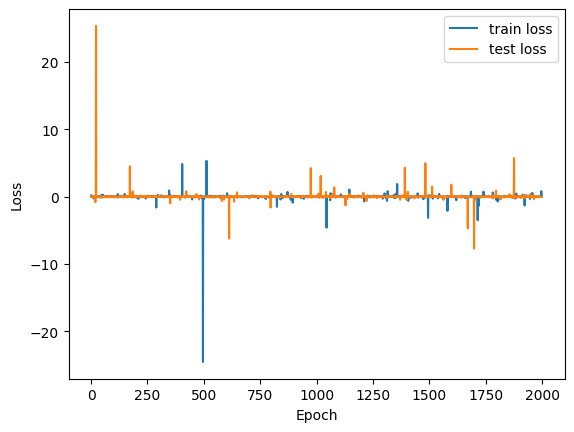

In [4]:
fig, ax = plt.subplots()

ax.plot(loss_train, label="train loss")
ax.plot(loss_test, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

Text(0, 0.5, 'True LLR')

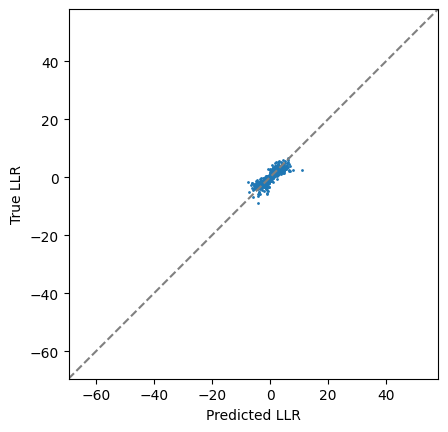

In [8]:
fig, ax = plt.subplots()

# param_1 = jnp.broadcast_to(jnp.array([0.01, 0.01]), (len(data), 2))
# param_0 = data.gen_parameters

key = jax.random.PRNGKey(0)
prior = UncorrelatedJointPrior(
    NormalParameterPrior(
        mean=jnp.zeros(2),
        cov=jnp.eye(2) * 0.1,
    )
)
param_0, param_1 = jax.vmap(prior.sample)(
    key=jax.random.split(key, len(data))
)

llr_pred = jax.vmap(model.llr_pred)(
    data.observables, param_0, param_1
)
llr_true = (
    jnp.log(data.likelihood(param_1))
    - jnp.log(data.likelihood(param_0))
)

amin = min(jnp.min(llr_pred).item(), jnp.min(llr_true).item())
amax = max(jnp.max(llr_pred).item(), jnp.max(llr_true).item())
ax.set_xlim(amin, amax)
ax.set_ylim(amin, amax)
ax.set_aspect("equal")

diag(ax)
ax.scatter(llr_pred, llr_true, s=1)
ax.set_xlabel("Predicted LLR")
ax.set_ylabel("True LLR")

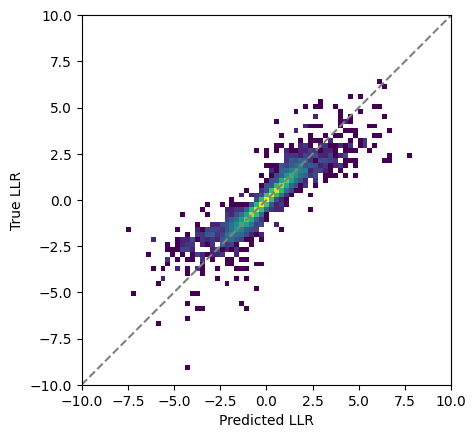

In [11]:
fig, ax = plt.subplots()

# param_1 = jnp.broadcast_to(jnp.array([0.01, 0.01]), (len(data), 2))
# param_0 = data.gen_parameters

key = jax.random.PRNGKey(0)
prior = UncorrelatedJointPrior(
    NormalParameterPrior(
        mean=jnp.zeros(2),
        cov=jnp.eye(2) * 0.1,
    )
)
param_0, param_1 = jax.vmap(prior.sample)(
    key=jax.random.split(key, len(data))
)

llr_pred = jax.vmap(model.llr_pred)(
    data.observables, param_0, param_1
)
llr_true = (
    jnp.log(data.likelihood(param_1))
    - jnp.log(data.likelihood(param_0))
)

amin = min(jnp.min(llr_pred).item(), jnp.min(llr_true).item())
amax = max(jnp.max(llr_pred).item(), jnp.max(llr_true).item())
ax.set_xlim(amin, amax)
ax.set_ylim(amin, amax)
ax.set_aspect("equal")

rang = [amin, amax]
rang = [-10, 10]

ax.hist2d(llr_pred, llr_true, bins=75, range=(rang, rang), rasterized=True, norm=LogNorm())
diag(ax)
ax.set_xlabel("Predicted LLR")
ax.set_ylabel("True LLR")

plt.savefig('physics-example.pdf', bbox_inches='tight')